## Northwind Database Analysis with Hypothesis Testing

- Name: Uma Palaniappan
- Cohort: Part-Time 
- Blog post URL: https://umapalam.github.io/hypothesis_testing_with_northwind


### Introduction
- Basic Goal: Examing Northwind database and analyze the schema with SQL and hypothesis testing

##### Step by Step 
1. Identify variables to compare by querying data
2. Seperate into comparison groups
3. Explore the data 
4. Form null and alternative hypothesis
5. Check to see if data is noramally distributed. (Normalization Graphs) 
6. Check variance and p-value
7. Check effect size - cohen's d
8. Form conclusions from analysis

### Import Libraries 

In [83]:
# import pandas and matplotlib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# import sqlite3 and database
import sqlite3
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()
# import numpy, seaborn, and scipy 
import seaborn as sns 
import numpy as np 
# import significance levels, normality, anova tools
from scipy import stats 
import itertools 
import statsmodels.api as sm 
from statsmodels.formula.api import ols
# hide warnings
import warnings
warnings.filterwarnings('ignore')

### List Tables

In [84]:
# List of all tables in schema 
c.execute("""SELECT name 
FROM sqlite_master 
WHERE type= 'table'
ORDER By name;""")
c.fetchall()

[('Category',),
 ('Customer',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Employee',),
 ('EmployeeTerritory',),
 ('Order',),
 ('OrderDetail',),
 ('Product',),
 ('Region',),
 ('Shipper',),
 ('Supplier',),
 ('Territory',)]

In [85]:
# turn the above code into a variable named tables 
tables = c.execute("""SELECT name
FROM sqlite_master 
WHERE type= 'table' 
"""). fetchall()
tables = [i[0] for i in tables]
print(tables)

['Employee', 'Category', 'Customer', 'Shipper', 'Supplier', 'Order', 'Product', 'OrderDetail', 'CustomerCustomerDemo', 'CustomerDemographic', 'Region', 'Territory', 'EmployeeTerritory']


In [86]:
# Loop to put all tables into pandas dataframes
dfs = []
for i in tables:
    table = c.execute('select * from "'+i+'"').fetchall()
    columns = c.execute('PRAGMA table_info("'+i+'")').fetchall()
    df = pd.DataFrame(table, columns=[i[1] for i in columns])
    # function to make a string into variable name
    conv = i+"_df"
    exec(conv + " = df") # => TableName_df
    # Keep all dataframe names in the list
    dfs.append(conv)
    print(conv)

Employee_df
Category_df
Customer_df
Shipper_df
Supplier_df
Order_df
Product_df
OrderDetail_df
CustomerCustomerDemo_df
CustomerDemographic_df
Region_df
Territory_df
EmployeeTerritory_df


### EDA (Exploratory Data Analysis)

In [87]:
# OrderDetail table has Discont 
c.execute("""SELECT * FROM 
OrderDetail""")

df = pd.read_sql_query("""SELECT * FROM 
OrderDetail""", conn)
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


Text(0.5, 1.0, 'Average Quantity by Discount')

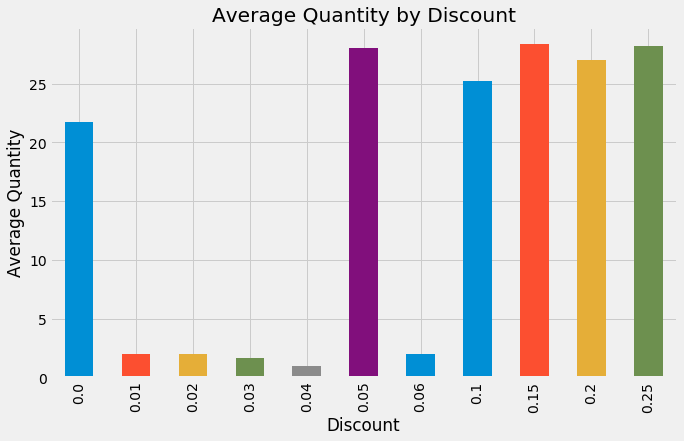

In [88]:
df = pd.read_sql_query("""SELECT * FROM 
OrderDetail""", conn)

plt.style.use('fivethirtyeight')
Discount = df.groupby('Discount')['Quantity'].mean().plot(kind='bar', figsize=(10,6))
Discount.set_ylabel('Average Quantity')
Discount.set_title('Average Quantity by Discount')

In [89]:
df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


### Functions

In [108]:
def sample_variance(sample):
    sample_mean = np.mean(sample)
    return np.sum((sample - sample_mean) **2)/ (len(sample) -1)

In [109]:
def pooled_variance(sample1, sample2):
    n_1, n_2 = len(sample1), len(sample2)
    var_1, var_2 = sample_variance(sample1), sample_variance(sample2)
    return ((n_1-1) * var_1 + (n_2-1)* var_2)/((n_1 + n_2)-2)

In [111]:
def twosample_tstatistic(expr, ctrl):
    exp_mean, ctrl_mean = np.mean(expr), np.mean(ctrl)
    pool_var = pooled_variance(expr, ctrl)
    n_e, n_c = len(expr), len(ctrl)
    num = exp_mean - ctrl_mean
    denom = np.sqrt(pool_var * ((1/n_e)+(1/n_c)))
    return num / denom

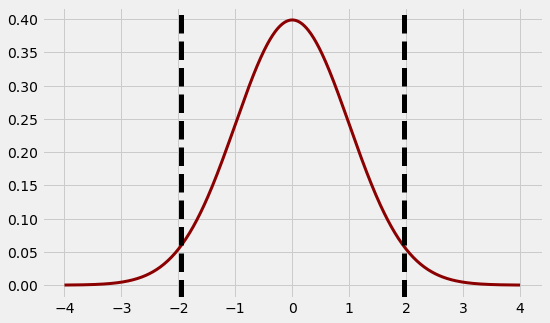

In [113]:
def visualize_t(t_stat, n_control, n_experimental):
    
    """
    Visualize the critical t values on a t distribution
    
    Parameters
    -----------
    t-stat: float
    n_control: int
    n_experiment: int
    
    Returns
    ----------
    None
    
    """
    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)

    # use stats.t.ppf to get critical value. For alpha = 0.05 and two tailed test
    crit = stats.t.ppf(1-0.025, (n_control+n_experimental-2))
    
    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(crit, color='black', linestyle='--', lw=5)
    ax.axvline(-crit, color='black', linestyle='--', lw=5)
    
    plt.show()
    return None

n_control = len(control)
n_experimental = len(experimental)
visualize_t(t_stat, n_control, n_experimental)

In [115]:
# Lower tail comulative density function returns area under the lower tail curve
lower_tail = stats.t.cdf(-1.89, (50+50-2), 0, 1)
# Upper tail comulative density function returns area under upper tail curve
upper_tail = 1. - stats.t.cdf(1.89, (50+50-2), 0, 1)

In [116]:
def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return abs(d)

In [ ]:
def welch_t(a,b, equal_var=False,describe = True ):
    dof_num = (a.var()/a.size + b.var()/b.size)**2
    dof_den =(a.var()/a.size)**2 / (a.size-1) + (b.var()/b.size)**2 / (b.size-1)
    dof = dof_num/dof_den
    test, p_val = stats.ttest_ind(a,b, equal_var = equal_var)
    if describe:
        print(f"Welch's t-test = {test}\np-value: {p_val}\nDoF: {dof}")
        if p_val<0.05:
            print('Decision: Reject the null hypothesis')
        else:
            print('Decision: Fail to reject the null hypothesis')
    return stats.ttest_ind(a,b, equal_var = False)

In [ ]:
def ANOVA(formula,data, decision=True):
    lm = ols(formula,data).fit()
    result = sm.stats.anova_lm(lm, typ=1)
    if decision:
        if result['PR(>F)'][0]>0.05:
            print('Fail to reject the Null Hypothesis')
        else:
            print('Reject the Null Hypothesis')
    return result

### Hypothesis Testing

The significance level (alpha value) is 0.05 (95% confidence interval) for all hypothesis testing questions. 

Question One: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

#### Null Hypothesis
- There is no difference in order quantity due to discount

#### Alternative Hypothesis
- There is an increase in order quantity due to discount

The significance level is 0.05

In [118]:
df1 = pd.read_sql_query("""SELECT Quantity, Discount FROM 
OrderDetail""", conn)
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [119]:
df1.describe()

,Quantity,Discount
count,2155.000000,2155.000000
mean,23.812993,0.056167
std,19.022047,0.083450
min,1.000000,0.000000
25%,10.000000,0.000000
50%,20.000000,0.000000
75%,30.000000,0.100000
max,130.000000,0.250000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c22260c18>,
      dtype=object)

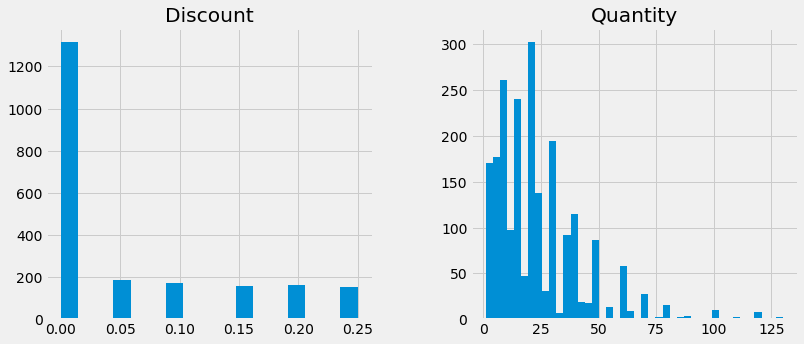

In [120]:
# Draw a histogram for pop ages
df1.hist(bins = 'auto', figsize=(12,5))

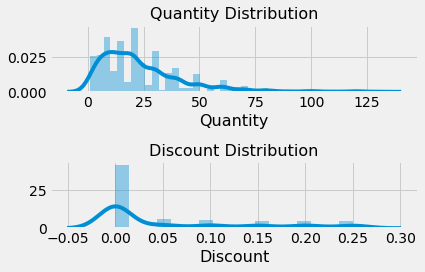

In [121]:
#dist plot of Quantity values
plt.subplot(211)
sns.distplot(df1['Quantity'], hist='density')
plt.title('Quantity Distribution', fontsize=16)
plt.xlabel('Quantity', fontsize=16)
#dist plot of discount values
plt.subplot(212)
sns.distplot(df1['Discount'], hist='density')
plt.title('Discount Distribution', fontsize=16)
plt.xlabel('Discount', fontsize=16)
plt.tight_layout()
plt.show()

In the first graph there is no normal distribution, "Quantity" is positively skewed.
The variable "Discount" has an almost even distribution with the exception of there being a large amount of orders with no discount. The bins for the "Discount" histogram are set in increments (5%, 10%, 15%, 20%, 25%). 

The control group are orders that did not recieve a discount. The experimental group are orders that did recieve a discount. 

In [122]:
# create control and experimental groups
control = df1[df1['Discount'] == 0]
ctrl = control['Quantity']
experimental = df1[df1['Discount'] != 0]
exp= experimental['Quantity']

In [123]:
# Difference between distribution means
control.mean()
experimental.mean()
experimental.mean() - control.mean()

Quantity    5.394523
Discount    0.144439
dtype: float64

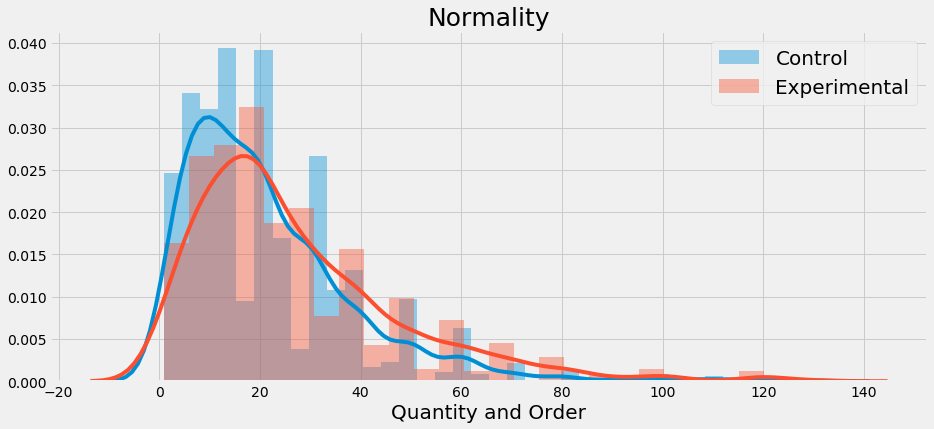

In [124]:
# Check for normality
plt.figure(figsize=(14,6))
sns.distplot(ctrl, label='Control')
sns.distplot(exp, label='Experimental',kde=True, hist=True )
plt.title('Normality', fontsize=25)
plt.xlabel('Quantity and Order', fontsize= 20)
plt.legend(fontsize= 20);

In [129]:
# calculate t statistic
t_stat = twosample_tstatistic(experimental, control)
t_stat

4.304937285665697

In [134]:
# Calculate p_value
p_value = lower_tail+upper_tail
print(p_value)

0.061713104303855494


In [135]:
stats.ttest_ind(experimental, control)

Ttest_indResult(statistic=4.304937285665697, pvalue=1.780928988051903e-05)

The p value for this experiment is higher than the alpha (significance level threshold). This means that we do not reject the null hypothesis. There is no difference in order quantity due to discount.

In [136]:
discounts_significance_df = pd.DataFrame(columns=['Discount %','Cohens d'], index=None)

discounts = [0.05, 0.1, 0.15, 0.2, 0.25]
control = df[df['Discount']==0]['Quantity']
for i in discounts:
    experimental = df[df['Discount']==i]['Quantity']
    st, p = stats.ttest_ind(control, experimental)
    d = Cohen_d(experimental, control)
    discounts_significance_df = discounts_significance_df.append( { 'Discount %' : str(i*100)+'%' , 'Null Hypothesis' : 'Reject' if p < 0.025 else 'Failed', 'Cohens d' : d } , ignore_index=True)    

discounts_significance_df

,Discount %,Cohens d,Null Hypothesis
0,5.0%,0.346877,Reject
1,10.0%,0.195942,Reject
2,15.0%,0.372404,Reject
3,20.0%,0.300712,Reject
4,25.0%,0.366593,Reject


The second part of the question asked at what levels does the discount become statistically significant to matter when it comes to how many orders were sold. There is no level of discount that is statistically significant enough to impact sales as all of their respective effect sizes were small from (0.1 to 0.3). There is no statistically significant difference in quantities between orders with no discount and applied discounts of 5%, 10%, 15%, 20%, 25%.

______________________

Question Two: Is there a significant difference in discounts given by employees from the United States and British Isles?

#### Null Hypothesis
- There is no difference in discounts given by employees in the United States and the British Isles.

#### Alternative Hypothesis
- There is a significant difference in discounts given by employees in the United States and the British Isles. 

In [155]:
df2 = pd.read_sql_query("""SELECT OrderDetail.Discount, Employee.Country 
FROM [Order] AS [Order]
JOIN OrderDetail AS OrderDetail ON [Order].Id = OrderDetail.OrderId
JOIN Employee AS Employee ON [Order].EmployeeId = Employee.Id""", conn)
df2.head(2)

,Discount,Country
0,0.0,UK
1,0.0,UK


In [167]:
df2.groupby('Country').count()

,Discount
Country,
UK,568
USA,1587


In [202]:
df2.groupby('Country').describe()

Discount                                               
           count      mean       std  min  25%  50%   75%   max
Country                                                        
UK         568.0  0.065493  0.085745  0.0  0.0  0.0  0.15  0.25
USA       1587.0  0.052829  0.082385  0.0  0.0  0.0  0.10  0.25

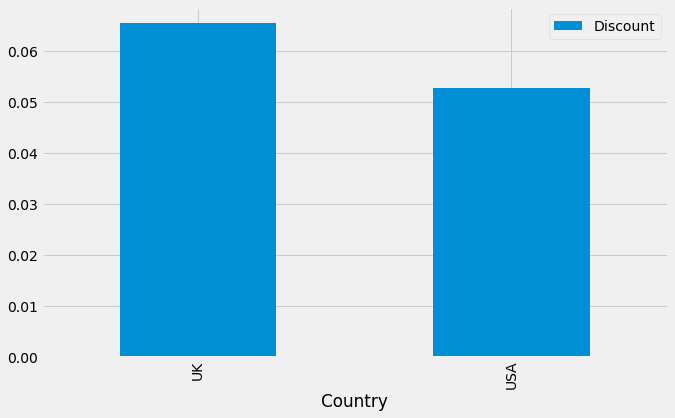

In [203]:
df2_graph = df2.groupby('Country').mean().plot(kind='bar', figsize=(10,6))

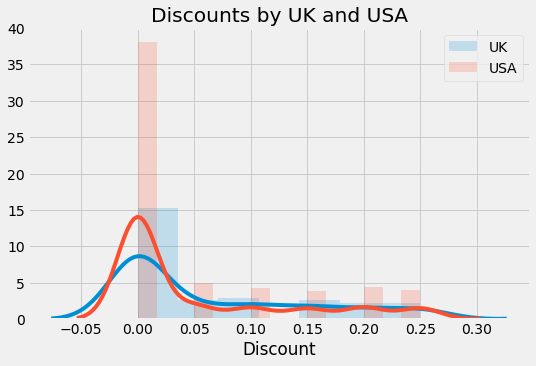

In [223]:
plt.figure(figsize=(8,5))
for country in set(df2.Country):
    x = df2.loc[df2['Country'] == country]
    sns.distplot(x['Discount'], hist_kws=dict(alpha=0.2), label=country)
    plt.legend()
    plt.title('Discounts by UK and USA')

In [224]:
# ANOVA
formula = 'Discount ~ C(Country)'
lm = ols(formula, df2).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

               sum_sq      df         F    PR(>F)
C(Country)   0.067081     1.0  9.671415  0.001896
Residual    14.933259  2153.0       NaN       NaN


In [232]:
us = df2.loc[df2['Country'] == 'USA']
uk = df2.loc[df2['Country'] == 'UK']
cd2 = Cohen_d(us,uk)
print("Cohen's d:", round(cd2,4))

Cohen's d: Discount    0.1521
dtype: float64


At 0.15 the effect size can be classified as small. The p value is 0.001 which is small in comparison to the 0.05 alpha which means that we reject the null hypothesis. There is a significant differnce in discounts given by employees in the United States and the British Isles.

______________


Question Three: Is there a significant difference in cost of orders by region?

#### Null Hypothesis
- There is no significant difference in cost of orders by region.

#### Alternative Hypothesis
- There is a significant difference in cost of orders by region.

In [164]:
df3 = pd.read_sql_query("""SELECT Customer.Region, OrderDetail.OrderId, 
    OrderDetail.Quantity, OrderDetail.UnitPrice, OrderDetail.Discount
 FROM Customer 
 JOIN [Order] ON Customer.Id = [Order].CustomerId
 JOIN OrderDetail ON OrderDetail.OrderId = [Order].Id""", conn)

In [165]:
df3.head(2)

,Region,OrderId,Quantity,UnitPrice,Discount
0,Western Europe,10248,12,14.0,0.0
1,Western Europe,10248,10,9.8,0.0


In [166]:
df3.groupby('Region').count()

,OrderId,Quantity,UnitPrice,Discount
Region,,,,
British Isles,190,190,190,190
Central America,55,55,55,55
Eastern Europe,16,16,16,16
North America,427,427,427,427
Northern Europe,143,143,143,143
Scandinavia,70,70,70,70
South America,304,304,304,304
Southern Europe,137,137,137,137
Western Europe,736,736,736,736


In [198]:
df3.groupby('Region').count()

,order_price
Region,
British Isles,75
Central America,21
Eastern Europe,7
North America,152
Northern Europe,55
Scandinavia,28
South America,127
Southern Europe,64
Western Europe,272


Text(0.5, 1.0, 'Regions')

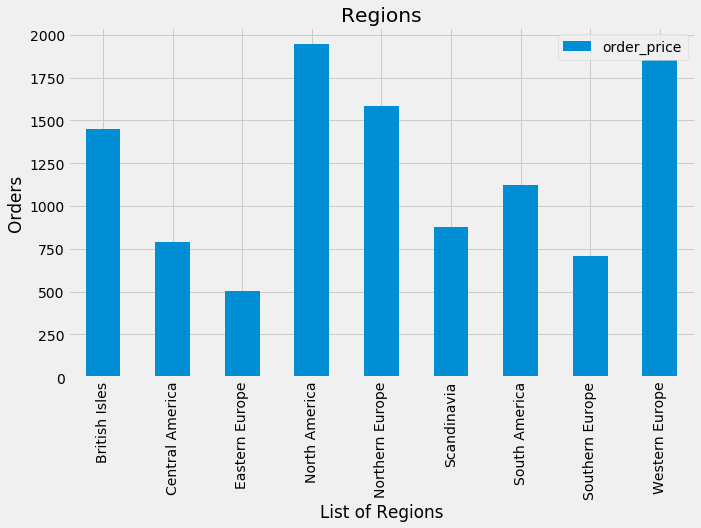

In [196]:
df3_graph = df3.groupby('Region').mean().plot(kind='bar', figsize=(10,6))
df3_graph.set_ylabel('Orders')
df3_graph.set_xlabel('List of Regions')
df3_graph.set_title('Regions')

In [199]:
df3.groupby('Region').describe()

order_price                                              \
                      count         mean          std     min       25%   
Region                                                                    
British Isles          75.0  1452.682867  1618.645044   45.00  461.8000   
Central America        21.0   788.480952   850.069075   88.80  360.0000   
Eastern Europe          7.0   504.564286   212.238861  160.00  413.6750   
North America         152.0  1945.926977  2209.578928   36.00  533.5500   
Northern Europe        55.0  1584.657500  1735.271109   48.75  607.5150   
Scandinavia            28.0   876.614375   701.336651  120.00  407.5125   
South America         127.0  1123.447307  1520.827652   12.50  375.1875   
Southern Europe        64.0   706.651836   730.213746   18.40  154.8500   
Western Europe        272.0  1851.280914  2054.829054   28.00  575.7500   

                                                  
                       50%         75%       max  
Region                                            
British Isles     997.0000  1879.80500  10835.24  
Central America   539.5000   954.40000   4150.05  
Eastern Europe    459.0000   638.80000    808.00  
North America    1260.9375  2411.43750  12615.05  
Northern Europe  1064.5000  2135.20625  11188.40  
Scandinavia       625.9250  1081.65000   2684.40  
South America     852.0000  1485.17500  15810.00  
Southern Europe   493.6000   994.00000   3026.85  
Western Europe   1319.0975  2150.05000  16387.50

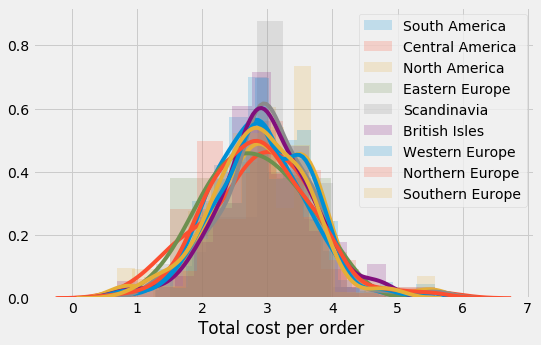

In [170]:
# region distribution
r_log = df3.copy()
r_log['UnitPrice'] = np.log(df3['UnitPrice'])
plt.figure(figsize=(8,5))
for region in set(r_log.Region):
    region_group = r_log.loc[r_log['Region'] == region]
    sns.distplot(region_group['UnitPrice'], hist_kws=dict(alpha=0.2), label=region)
    plt.legend()
    plt.xlabel('Total cost per order ')

In [178]:
# ANOVA table
lm = ols('UnitPrice ~ C(Region)', r_log).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(Region),5.303353,8.0,1.12672,0.341687
Residual,1217.320234,2069.0,NaN,NaN


In [234]:
b = df3.loc[df3['Region'] == 'British Isles']
na = df3.loc[df3['Region'] == 'North America']
cd3 = Cohen_d(b,na)
print("Cohen's d:", round(cd3,4))

Cohen's d: order_price    0.2426
dtype: float64


Looking at the table, we can see that the p value is 0.34 and is more than the 0.05 alpha. This means we can not reject the null hypothesis. The cost of orders by region is not varied. The amount of orders sold by region does differ from one another. 

______________

Question Four: Is there a significant difference in terms of cost for carriers?

##### Null Hypothesis

- There is no significant difference between carriers in terms of cost. 

##### Alternative Hypothesis

- There is a significant difference between carriers in terms of cost. 

In [236]:
df4 = pd.read_sql_query("""SELECT Supplier.Region, [Order].ShipRegion, [Order].freight
                            FROM [Order] AS [Order]
                          JOIN [OrderDetail] AS OrderDetail ON [Order].ID == OrderDetail.OrderID
                          JOIN [Product] AS Product ON OrderDetail.ProductID == Product.ID
                          JOIN [Supplier] AS Supplier ON Supplier.ID == Product.SupplierID""", conn)

In [237]:
df4.head(2)

,Region,ShipRegion,Freight
0,Southern Europe,Western Europe,32.38
1,South-East Asia,Western Europe,32.38


In [239]:
df4.describe()

,Freight
count,2155.000000
mean,96.197726
std,133.011272
min,0.020000
25%,19.610000
50%,53.800000
75%,120.920000
max,1007.640000


Text(0.5, 1.0, 'Regions')

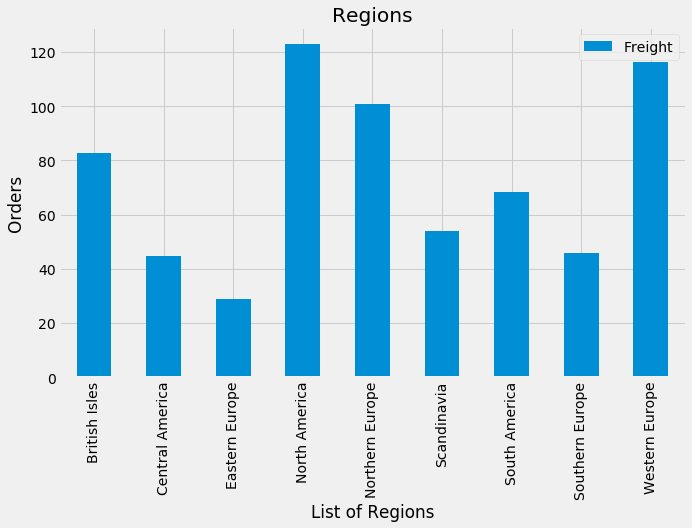

In [258]:
df4_graph = df4.groupby('ShipRegion').mean().plot(kind='bar', figsize=(10,6))
df4_graph.set_ylabel('Orders')
df4_graph.set_xlabel('List of Regions')
df4_graph.set_title('Regions')

In [238]:
# c_cost is control eand e_cost is experimental 
c_cost = df4[df4['Region'] == df4['ShipRegion']]['Freight']
print('c_cost statistics',c_cost.describe())
e_cost = df4[df4['Region'] != df4['ShipRegion']]['Freight']
print('e_cost statistics',e_cost.describe())

c_cost statistics count     299.000000
mean      117.629331
std       159.332480
min         0.150000
25%        23.290000
50%        64.560000
75%       147.060000
max      1007.640000
Name: Freight, dtype: float64
e_cost statistics count    1856.000000
mean       92.745113
std       127.982115
min         0.020000
25%        18.635000
50%        52.920000
75%       112.490000
max      1007.640000
Name: Freight, dtype: float64


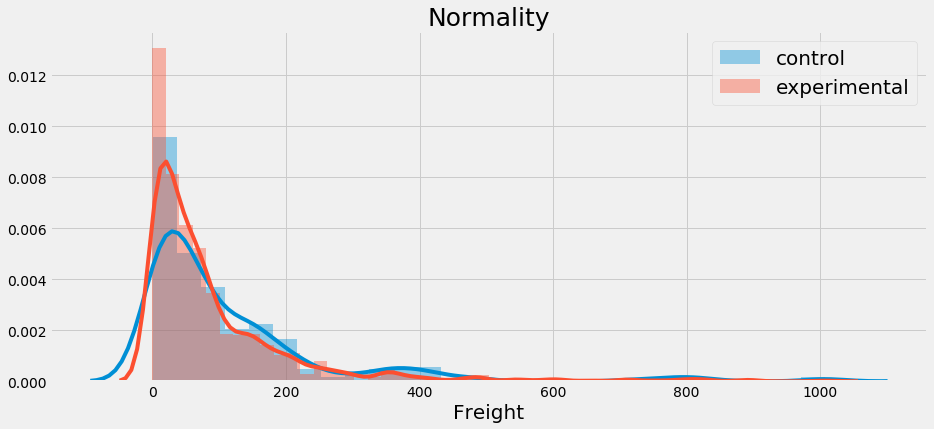

In [263]:
plt.figure(figsize=(14,6))
sns.distplot(c_cost, label='control')
sns.distplot(e_cost, label='experimental',kde=True, hist=True )
plt.title('Normality', fontsize=25)
plt.xlabel('Freight', fontsize= 20)
plt.legend(fontsize= 20);

In [242]:
def cd(a,b, describe = True):
    a_n,b_n = len(a),len(b)
    pv_num = ((a_n-1)*a.var())+((b_n-1)*b.var())
    pv_den = a_n+b_n
    pooled_sd = np.sqrt(pv_num/pv_den)
    d = (a.mean()-b.mean())/pooled_sd
    if describe:
        print("Cohens'd: ",d)
        if d<0.50:
            print('Effect Size: Small')
        elif d<0.80:
            print('Effect Size: Medium')
        else:
            print('Effect Size: Large')
    return d

In [248]:
def w_t(a,b, equal_var=False,describe = True ):
    dof_num = (a.var()/a.size + b.var()/b.size)**2
    dof_den =(a.var()/a.size)**2 / (a.size-1) + (b.var()/b.size)**2 / (b.size-1)
    dof = dof_num/dof_den
    test, p_val = stats.ttest_ind(a,b, equal_var = equal_var)
    if describe:
        print(f"Welch's t-test = {test}\np-value: {p_val}\nDoF: {dof}")
        if p_val<0.05:
            print('Decision: Reject the null hypothesis')
        else:
            print('Decision: Fail to reject the null hypothesis')
    return stats.ttest_ind(a,b, equal_var = False)

In [250]:
print('Equal variance test:')
if stats.levene(c_cost,e_cost)[1]<0.05:
    print('Input samples are not from populations with equal variances.')
else:
    print('Input samples are from populations with equal variances.')
print('Hypothesis Testing:')
welch = w_t(c_cost,e_cost)
print('Effect size Testing:')
d = cd(c_cost,e_cost)

Equal variance test:
Input samples are not from populations with equal variances.
Hypothesis Testing:
Welch's t-test = 2.570292317793137
p-value: 0.010559865355354837
DoF: 362.538552340464
Decision: Reject the null hypothesis
Effect size Testing:
Cohens'd:  0.18751968413624498
Effect Size: Small


The effect size is small so there is not a strong relationship between the variables. The p value is 0.01 is less than 0.05 (alpha) which means we reject the null hypothesis. There is a significant difference in terms of cost for carriers. 

_____________

### Conclusion

- Discounts of 5%, 15%, 20% and 25% have approximately the same effect on order quantity. But there is a difference when there is no discount added to a product. 
- Employees from US sold more product with lower discount, though order quantity is the same as employees from the UK. The US employees did better profit wise because they gave fewer discounts. 
- Between different regions, certain regions like Western Europe placed more orders. The North American region spends more on products per order in comparison to other regions. The unit cost of orders per region do not differ significantly. 
- Whatever carrier is used to deliver orders does impact the cost. Some carriers are more expensive than others.  


- Find out why employees from US had much more orders than from UK. 
- Research further in which regions that clients responded better to discounts. 
- Focus on regions that do not order as much products. 
- Research alternative carriers that have a lower cost. 